In [4]:
import sys; sys.path.append('../src/playground_jax')
from functools import partial
from time import time

from jax import numpy as jnp, random, nn
from jax import grad, value_and_grad, vmap, jit
from jaxtyping import Array, PyTree
import flax
import optax
import matplotlib.pyplot as plt

from models_flax import *

Goal: fit a scalar real-valued funciton
$ f: D \subset \mathbb{R} \rightarrow \mathbb{R}$

1. Generate training data

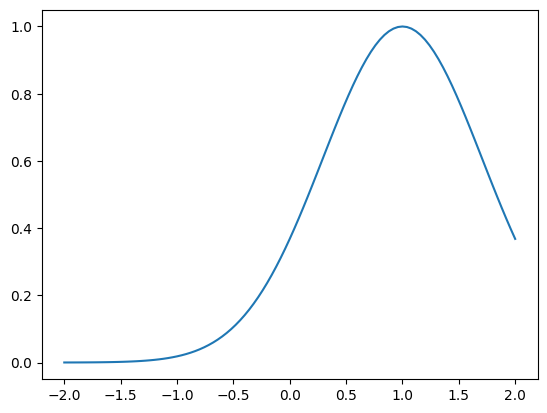

In [5]:
N = 101
x = jnp.expand_dims(jnp.linspace(-2, 2, N), axis=-1)
#y = jnp.sqrt(jnp.abs(x))
#y = x**2
y = jnp.exp(-(x - 1)**2)
#x = jnp.expand_dims(jnp.linspace(0, 2*jnp.pi, N), axis=-1)
#y = jnp.sin(x)
fig, ax = plt.subplots()
ax.plot(x, y)
plt.show()

2. build a model

In [7]:
# set a random key
key = random.PRNGKey(1)

# define model
d_in, d_out = 1, 1
features = [32, 32] + [d_out]
#model = MLP(features, nn.tanh, lambda x: x)
model = DenseNN(features, nn.tanh, lambda x: x)

# initialize variables
key, split = random.split(key)
input = jnp.ones(d_in)
params = model.init(key, input)

In [8]:
# evaluate model
batch_size = int(1e3)
input = random.normal(key, (batch_size, d_in), jnp.float32) 
model.apply(params, input).shape

(1000, 1)

3. Define loss (mean square error loss)

In [9]:
@jit
def loss_fn(params: flax.core.frozen_dict.FrozenDict, x, y):
    pred_y = vmap(model.apply, in_axes=(None, 0))(params, x)
    return jnp.mean((y - pred_y) ** 2)

4. Choose optimizer

In [11]:
lr = 1e-3
wd = 1e-5

# using optax
opt = optax.adamw(learning_rate=lr, weight_decay=wd)
opt_state = opt.init(params)

5. Update function

In [12]:
@jit
def update_fn(params, opt_state: PyTree, x: Array, y: Array):
    
    # compute gradients and loss value
    loss, grads = value_and_grad(loss_fn)(params, x, y)

    # optimizer upate
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

6. Train

In [14]:
n_iter = int(1e4)
log_period_iter = int(1e3)
for i in range(n_iter):
    t0 = time()
    #loss, params, opt_state = update_fn(model, params, opt_state, x, y)
    loss, params, opt_state = update_fn(params, opt_state, x, y)
    t1 = time()
    if i % log_period_iter  == 0: 
        print('it: {:d}, loss: {:.3e}, time: {:.4f}s'.format(i, loss, t1-t0))

it: 0, loss: 2.816e-01, time: 0.2297s
it: 1000, loss: 5.834e-04, time: 0.0001s
it: 2000, loss: 1.094e-05, time: 0.0000s
it: 3000, loss: 2.996e-06, time: 0.0000s
it: 4000, loss: 9.793e-07, time: 0.0000s
it: 5000, loss: 3.415e-06, time: 0.0000s
it: 6000, loss: 3.067e-07, time: 0.0000s
it: 7000, loss: 2.177e-07, time: 0.0000s
it: 8000, loss: 1.581e-07, time: 0.0000s
it: 9000, loss: 5.698e-07, time: 0.0000s


7. Evaluate results

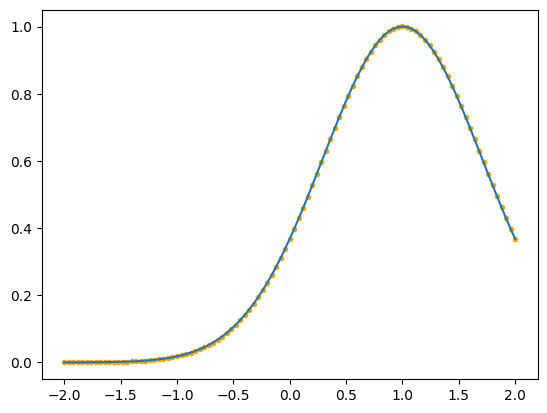

In [15]:
y_pred = model.apply(params, x)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.scatter(x, y_pred, c='orange', marker='.')
plt.show()